In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import shelve
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pymongo import MongoClient
import math

from scripts import blazmass_tools
from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis import taxonomy
from scripts.analysis import DBInfo

In [2]:
# Load data
BASE = '../data'
OUT = BASE + '/tax_data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
samp_names = list(metadata.index)

In [21]:
# Fix sample titles to match what we're calling them in manuscript
metadata['category'] = metadata['category'].str.replace('RT', 'IBD')

In [3]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))

n14_samps = [x[0] for x in pairs]
n15_samps = [x[1] for x in pairs]

n14_un_samps = [x for x in n14_samps if x.startswith('UL_')]
n15_un_samps = [x for x in n15_samps if x.startswith('UL_')]

n14_enr_samps = [x for x in n14_samps if x.startswith('CL_')]
n15_enr_samps = [x for x in n15_samps if x.startswith('CL_')]

In [4]:
all_dfs = defaultdict(dict)

for rank in ['family', 'phylum']:
    all_dfs[rank] = pd.read_csv(os.path.join(OUT,"{}_count.csv".format(rank)), index_col=0)

In [5]:
all_dfs['phylum'].head()

,count,organism_name,taxid,sample
7711,1690.711194,chordata,7711,CL_Mix_Pool_N_5
1117,865.068930,cyanobacteria,1117,CL_Mix_Pool_N_5
1239,316.220212,firmicutes,1239,CL_Mix_Pool_N_5
976,248.654522,bacteroidetes,976,CL_Mix_Pool_N_5
74201,167.588248,verrucomicrobia,74201,CL_Mix_Pool_N_5


In [6]:
def plot_tax(rank, samples):
    from matplotlib.ticker import FuncFormatter
    from itertools import cycle
    import matplotlib
    
    def to_percent(y, position):
        s = str(100 * y)
        if matplotlib.rcParams['text.usetex'] is True:
            return s + r'$\%$'
        else:
            return s + '%'
    
    sns.set_style('whitegrid')
    
    all_df = all_dfs[rank]
    f = plt.figure(figsize=(8,6))
    #f = plt.figure()
    df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
    order = ['other'] + list(df_pivot.sum().sort_values().index)
    df_pivot = df_pivot.loc[samples]
    
    bad_fams = ['muridae', 'poaceae', 'hominidae', 'phormidiaceae']
    bad_phyla = ['chordata', 'cyanobacteria']
    
    if rank == "family":
        for bad_fam in bad_fams:
            if bad_fam in df_pivot:
                del df_pivot[bad_fam]
    elif rank == "phylum":
        for bad_phylum in bad_phyla:
            if bad_phylum in df_pivot:
                del df_pivot[bad_phylum]
    df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
    
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
    df_pivot = df_pivot[[o for o in order if o in df_pivot]]
    other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
    df_pivot['other'] = other
    df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]
    df_pivot.index = [metadata.loc[x, 'category'].split(' ')[0]+' '+str(metadata.loc[x, 'technical']) for x in df_pivot.index]
    df_pivot = df_pivot.sort_index()

    # Filter out missing famalies for consistant coloring
    colors = sns.color_palette("cubehelix", 8)
    order = [o for o in order if not o in bad_fams+bad_phyla]
    c_dict = dict(zip(order[::-1], cycle(colors[::-1])))
    
    ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca(),  color=map(c_dict.get,df_pivot.columns))
    lgd = plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size':12})
    ax.set_ylabel("Normalized Count", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 12)
    ax.title.set_fontsize(20)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    f.subplots_adjust(right=0.8)

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


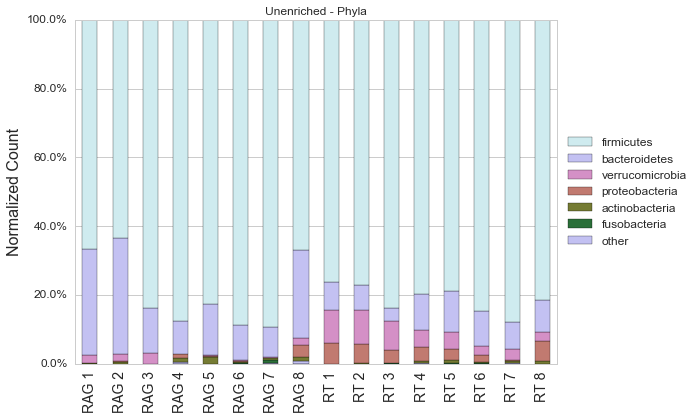

In [7]:
plot_tax("phylum", n14_un_samps + n15_un_samps)
plt.title('Unenriched - Phyla')
#plt.savefig(os.path.join(OUT,"Unenr_phlya.pdf"), bbox_inches='tight');

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


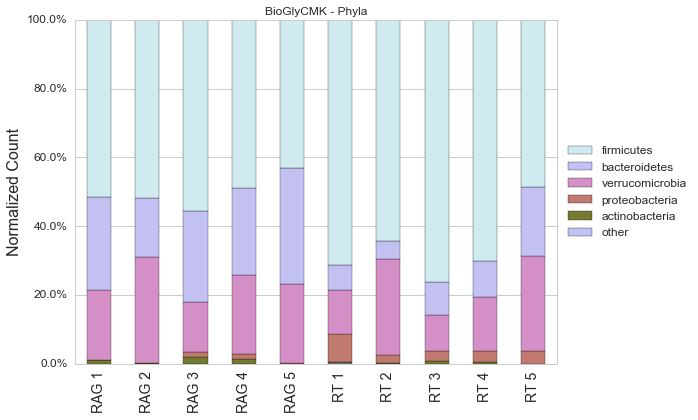

In [8]:
plot_tax("phylum", n14_enr_samps + n15_enr_samps)
plt.title('BioGlyCMK - Phyla')
#plt.savefig(os.path.join(OUT,"BioGlyCMK_phlya.pdf"), bbox_inches='tight');

Enrichment seems to filter out some firmicutes, and leave you with more verrucomicrobia

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


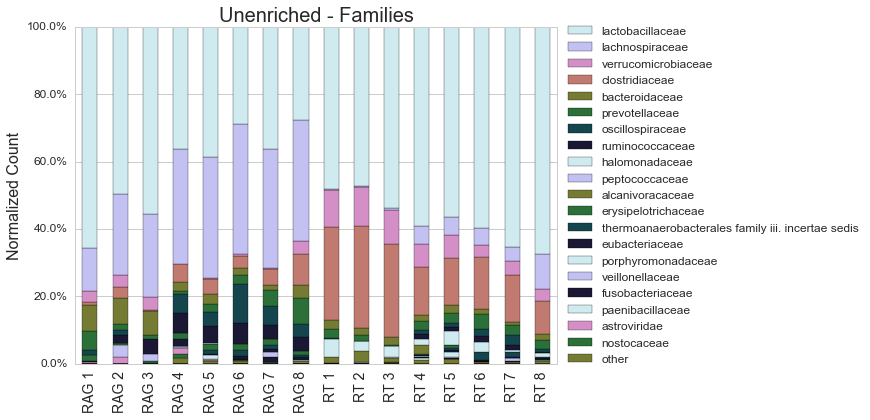

In [9]:
plot_tax("family", n14_un_samps+n15_un_samps)
plt.title('Unenriched - Families', size = 20)
plt.savefig(os.path.join(OUT,"Unenr_fams.svg"), bbox_inches='tight');

Big Changes:  
RT : Decrease in lachnospiracae.   Increase in clostridiaceae, verrucomicrobiaceae  

Subtle changes:  
RAG: More bacteroidaceae, more oscillospiraceae, more ruminococcaceae  
RT: More Halomondaceae

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


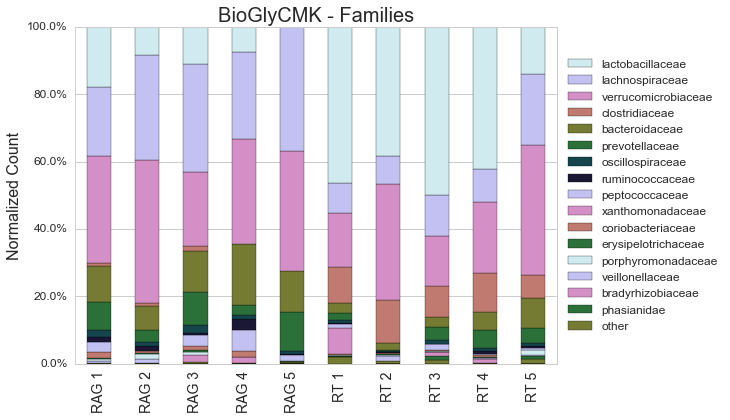

In [10]:
plot_tax("family", n14_enr_samps+n15_enr_samps)
plt.title('BioGlyCMK - Families', size=20)
plt.savefig(os.path.join(OUT,"tax_enr_fams.svg"), bbox_inches='tight');

Big Changess: RT: more lactobacillaceae, more clostridaceae, less lachnospiraceae, less bacterodiaceae 

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


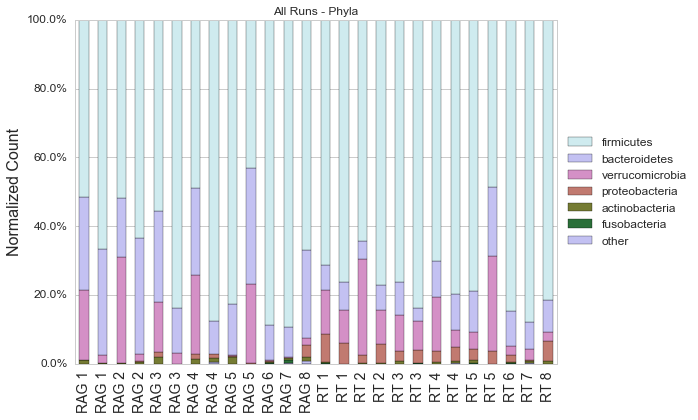

In [11]:
plot_tax('phylum', samp_names)
plt.title('All Runs - Phyla')
#plt.savefig(os.path.join(OUT,"All_phlya.pdf"), bbox_inches='tight');

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


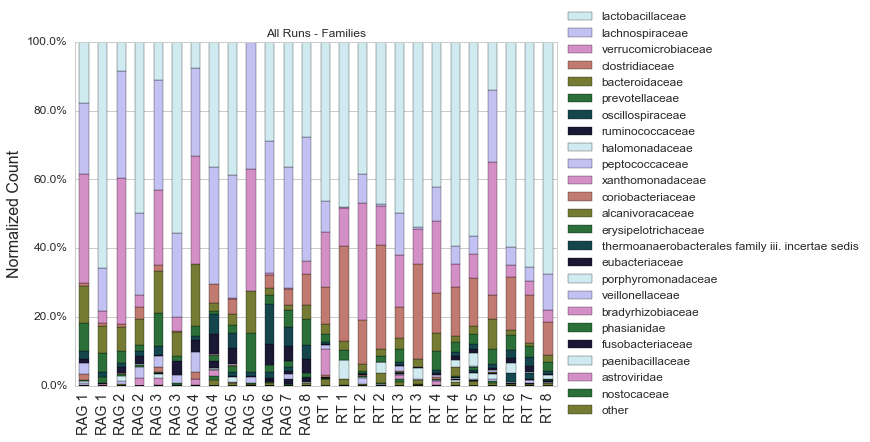

In [12]:
plot_tax('family', samp_names)
plt.title('All Runs - Families')
#plt.savefig(os.path.join(OUT,"all_fams.pdf"), bbox_inches='tight');

Enriched vs unenriched changes:  
Enriched has far more verrucomicrobiaceae and far fewer lactobacillaceae  

Enriched also seems to pick up more bacteroidaceae (especially in RAG)

In [13]:
all_dfs['family'].head()

,count,organism_name,taxid,sample
10066,1468.728914,muridae,10066,CL_Mix_Pool_N_5
186803,173.947429,lachnospiraceae,186803,CL_Mix_Pool_N_5
203557,167.588248,verrucomicrobiaceae,203557,CL_Mix_Pool_N_5
815,57.545425,bacteroidaceae,815,CL_Mix_Pool_N_5
171552,54.488874,prevotellaceae,171552,CL_Mix_Pool_N_5


In [47]:
rank = 'family'
samples = n14_un_samps+n15_un_samps

from matplotlib.ticker import FuncFormatter
from itertools import cycle
import matplotlib

def to_percent(y, position):
    s = str(100 * y)
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

sns.set_style('whitegrid')

all_df = all_dfs[rank]
f = plt.figure(figsize=(8,6))
#f = plt.figure()
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
order = ['other'] + list(df_pivot.sum().sort_values().index)
df_pivot = df_pivot.loc[samples]

bad_fams = ['muridae', 'poaceae', 'hominidae', 'phormidiaceae']
bad_phyla = ['chordata', 'cyanobacteria']

if rank == "family":
    for bad_fam in bad_fams:
        if bad_fam in df_pivot:
            del df_pivot[bad_fam]
elif rank == "phylum":
    for bad_phylum in bad_phyla:
        if bad_phylum in df_pivot:
            del df_pivot[bad_phylum]

In [48]:
df_pivot.head()

organism_name,acidaminococcaceae,alcanivoracaceae,alteromonadaceae,astroviridae,bacillaceae,bacteroidaceae,blattabacteriaceae,bradyrhizobiaceae,brucellaceae,burkholderiaceae,...,rikenellaceae,ruminococcaceae,spiroplasmataceae,streptococcaceae,thermoanaerobacterales family iii. incertae sedis,tremellaceae,veillonellaceae,verrucomicrobiaceae,vibrionaceae,xanthomonadaceae
sample,,,,,,,,,,,,,,,,,,,,,
UL_Mix_1111_1,NaN,22.0,NaN,NaN,2.0,34.084678,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,143.0,NaN,NaN
UL_Mix_1111_2,NaN,45.0,NaN,NaN,NaN,30.517516,NaN,NaN,NaN,NaN,...,NaN,0.279266,NaN,NaN,NaN,1.0,4.105033,172.0,NaN,NaN
UL_Mix_1111_3,NaN,19.0,1.0,NaN,NaN,43.000000,NaN,NaN,NaN,NaN,...,NaN,4.440869,NaN,NaN,1.0,NaN,NaN,187.0,NaN,NaN
UL_Mix_1121_1,NaN,53.0,NaN,NaN,NaN,33.899451,2.0,NaN,1.0,NaN,...,NaN,25.439071,1.0,3.928596,NaN,NaN,2.000000,130.0,NaN,NaN
UL_Mix_1121_2,NaN,NaN,NaN,NaN,1.0,47.239482,2.0,NaN,1.0,NaN,...,NaN,23.240069,1.0,7.000000,12.0,0.0,1.000000,137.0,NaN,NaN


In [49]:
#df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[[o for o in order if o in df_pivot]]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]
df_pivot.index = [metadata.loc[x, 'category'].split(' ')[0]+' '+str(metadata.loc[x, 'technical']) for x in df_pivot.index]
df_pivot = df_pivot.sort_index()

In [50]:
df_pivot.head()

organism_name,other,nostocaceae,astroviridae,paenibacillaceae,fusobacteriaceae,veillonellaceae,porphyromonadaceae,eubacteriaceae,thermoanaerobacterales family iii. incertae sedis,erysipelotrichaceae,...,peptococcaceae,halomonadaceae,ruminococcaceae,oscillospiraceae,prevotellaceae,bacteroidaceae,clostridiaceae,verrucomicrobiaceae,lachnospiraceae,lactobacillaceae
IBD 1,0.001534,0.0,NaN,NaN,NaN,NaN,NaN,0.000384,0.000767,NaN,...,NaN,0.054440,NaN,0.001700,0.027603,0.026135,0.277565,0.109646,0.002169,0.481190
IBD 2,0.002682,NaN,NaN,NaN,NaN,0.002752,NaN,NaN,NaN,0.001352,...,NaN,0.031513,0.000187,0.000152,0.016900,0.020461,0.301803,0.115323,0.004261,0.472441
IBD 3,0.004896,NaN,NaN,0.000544,NaN,NaN,0.000000,NaN,0.000544,0.000544,...,0.002720,0.032097,0.002416,NaN,0.001265,0.023393,0.275929,0.101732,0.004841,0.538742
IBD 4,0.011129,NaN,NaN,0.007053,0.000517,0.001033,0.003100,0.003310,NaN,0.001550,...,NaN,0.019118,0.013144,0.011985,0.027460,0.017516,0.142895,0.067170,0.052975,0.592662
IBD 5,0.012852,NaN,NaN,0.001518,0.004049,0.000506,0.017206,0.004181,0.006073,0.009615,...,0.000506,0.039979,0.011761,0.012565,0.030364,0.023906,0.137650,0.069331,0.054176,0.563760


In [55]:
dat = df_pivot.reset_index()
dat = dat.rename(columns={'index': 'cohort'})

In [57]:
dat['cohort'] = dat['cohort'].str.split(' ').str[0]

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


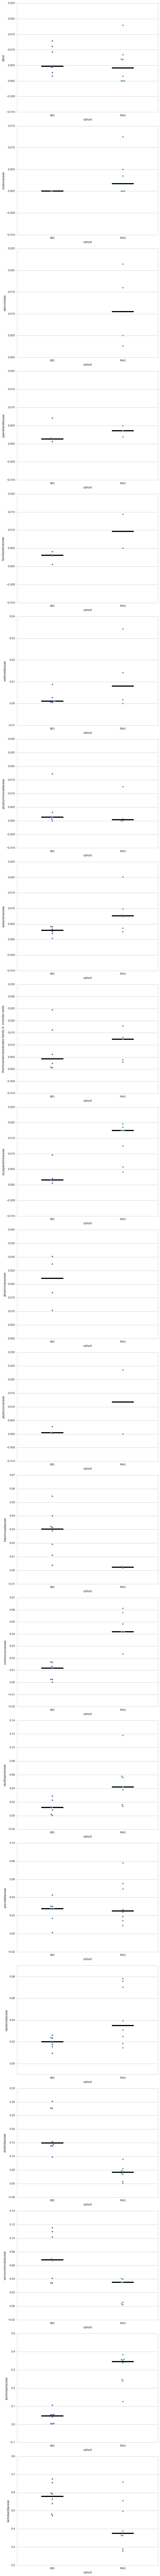

In [81]:
fams = list(dat.columns)
fams.remove('cohort')
n_fams = len(fams)

fig, ax = plt.subplots(n_fams, 1)
fig.set_size_inches(8, 6*n_fams)


for i, fam in enumerate(fams):

    sns.swarmplot(y=fam, x='cohort', data=dat, ax = ax[i])

    # distance across the "X" or "Y" stipplot column to span, in this case 40%
    median_width = 0.3

    for tick, text in zip(ax[i].get_xticks(), ax[i].get_xticklabels()):
        cohort_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = dat.query('cohort == "{}"'.format(cohort_name))[fam].median()

        # plot horizontal lines across the column, centered on the tick
        ax[i].plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=4, color='k')
    ax[i].set

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


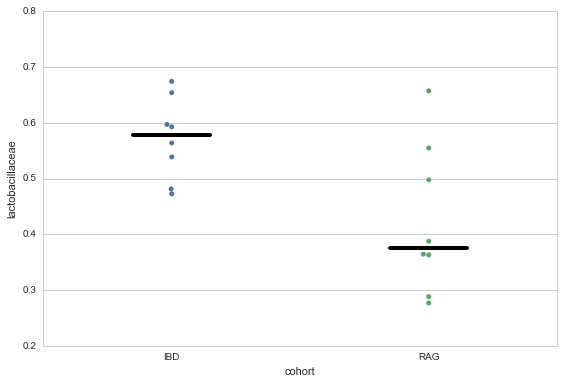

In [80]:
    fig, ax = plt.subplots(1,1)
    
    sns.swarmplot(x = 'cohort', y=fam, data = dat)
    
    # distance across the "X" or "Y" stipplot column to span, in this case 40%
    median_width = 0.3

    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        cohort_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = dat.query('cohort == "{}"'.format(cohort_name))[fam].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=4, color='k')
    fig.

In [83]:
rank = 'family'
samples = n14_enr_samps+n15_enr_samps

from matplotlib.ticker import FuncFormatter
from itertools import cycle
import matplotlib

def to_percent(y, position):
    s = str(100 * y)
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

sns.set_style('whitegrid')

all_df = all_dfs[rank]
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
order = ['other'] + list(df_pivot.sum().sort_values().index)
df_pivot = df_pivot.loc[samples]

bad_fams = ['muridae', 'poaceae', 'hominidae', 'phormidiaceae']
bad_phyla = ['chordata', 'cyanobacteria']

if rank == "family":
    for bad_fam in bad_fams:
        if bad_fam in df_pivot:
            del df_pivot[bad_fam]
elif rank == "phylum":
    for bad_phylum in bad_phyla:
        if bad_phylum in df_pivot:
            del df_pivot[bad_phylum]

In [84]:
#df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[[o for o in order if o in df_pivot]]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]
df_pivot.index = [metadata.loc[x, 'category'].split(' ')[0]+' '+str(metadata.loc[x, 'technical']) for x in df_pivot.index]
df_pivot = df_pivot.sort_index()

In [85]:
dat = df_pivot.reset_index()
dat = dat.rename(columns={'index': 'cohort'})

In [86]:
dat['cohort'] = dat['cohort'].str.split(' ').str[0]

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


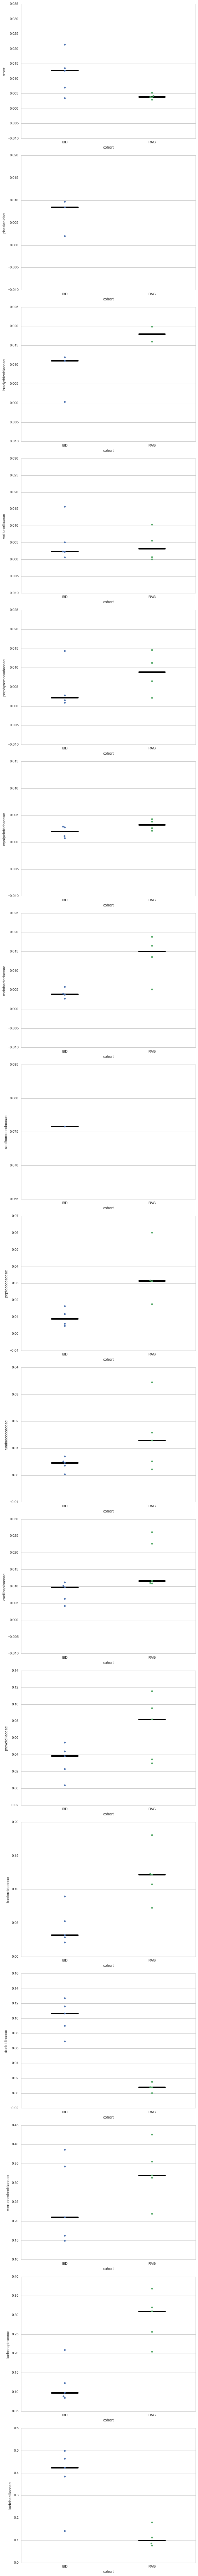

In [87]:
fams = list(dat.columns)
fams.remove('cohort')
n_fams = len(fams)

fig, ax = plt.subplots(n_fams, 1)
fig.set_size_inches(8, 6*n_fams)


for i, fam in enumerate(fams):

    sns.swarmplot(y=fam, x='cohort', data=dat, ax = ax[i])

    # distance across the "X" or "Y" stipplot column to span, in this case 40%
    median_width = 0.3

    for tick, text in zip(ax[i].get_xticks(), ax[i].get_xticklabels()):
        cohort_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = dat.query('cohort == "{}"'.format(cohort_name))[fam].median()

        # plot horizontal lines across the column, centered on the tick
        ax[i].plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=4, color='k')
    ax[i].set